## Product Recommendation Systems

Recommender Systems are simple algorithms which aim to provide the most relevant and accurate items to the user by filtering useful stuff from of a huge pool of information base. Recommendation engines discovers data patterns in the data set by learning consumers choices and produces the outcomes that co-relates to their needs and interests.

Everyday a million products are being recommended to users based on popularity and other metrics on e-commerce websites. The most popular e-commerce website boosts average order value by 50%, increases revenues by 300%, and improves conversion. In addition to being a powerful tool for increasing revenues, product recommendations are so essential that customers now expect to see similar features on all other eCommerce sites.

Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) The repository has several datasets. For this case study, we are using the Electronics
dataset.

In [1]:
#Import Required basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import the packages required for recommendation system. 
# Surprise package is not available in python environment by default. We need to install tha package in kernal first.
# Since we are using surprise package, we need to make sure that test_train_split is launched from surprise package. 
# We have test_train_split in sklearn as well, but that might not work for recommendation systems
import sklearn
from sklearn.decomposition import TruncatedSVD
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from sklearn.metrics.pairwise import cosine_similarity
from surprise.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
# Reading the dataset
ratings=pd.read_csv("ratings_Electronics.csv")

First three columns are userId, productId, and ratings and the fourth column is timestamp. Timestamp can be ignored for now

In [4]:
# Assigning the column name for the dataset since title is not available in the dataset
ratings.columns=['userId','productId','ratings','timestamp']

#### Understanding the Data

In [5]:
ratings.head()

,userId,productId,ratings,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [6]:
ratings.shape

(7824481, 4)

In [7]:
ratings.dropna(axis=0,inplace=True)

In [8]:
#There are no Na/NaN values in the dataset & so the row count is same as above
ratings.shape

(7824481, 4)

In [9]:
#There are no NULL values in the dataset 
ratings.isnull().sum()

userId       0
productId    0
ratings      0
timestamp    0
dtype: int64

In [10]:
#Let us understand how the products are rated across the dataset
ratings.describe()['ratings']

count    7.824481e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: ratings, dtype: float64

It could be seen that products are rated between 1 & 5. Most of the products are rated around 4-5 & hence the average of the products is above 4

In [11]:
# Distinct number of users & products available in dataset
print("Distinct # users",len(ratings['userId'].unique()))
print("Distinct # products",len(ratings['productId'].unique()))

Distinct # users 4201696
Distinct # products 476001


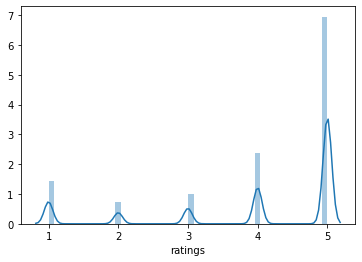

In [12]:
sns.distplot(ratings['ratings'])

Most of the products are rated 5 & the least number of products rated is rated as 2

#### Product Analysis

In [13]:
# Now let us remove the timestamp column & group the dataset by product
rpmeancount = pd.DataFrame(ratings.groupby('productId')['ratings'].mean())
rpmeancount['counts'] = pd.DataFrame(ratings.groupby('productId')['ratings'].count())
rpmeancount.tail()

,ratings,counts
productId,,
BT008G3W52,5.0,1
BT008SXQ4C,1.0,1
BT008T2BGK,5.0,1
BT008UKTMW,4.0,15
BT008V9J9U,5.0,1


In [14]:
# Out of 476001 available distinct products, one product alone has received 18244 ratings. 
# This could be the most popular product in Amazon dataset
rpmeancount['counts'].max()

18244

In [15]:
# 5 Point analysis for the products
rpmeancount.describe()

,ratings,counts
count,476001.000000,476001.000000
mean,3.889698,16.437951
std,1.128719,112.702749
min,1.000000,1.000000
25%,3.272727,1.000000
50%,4.000000,2.000000
75%,5.000000,7.000000
max,5.000000,18244.000000


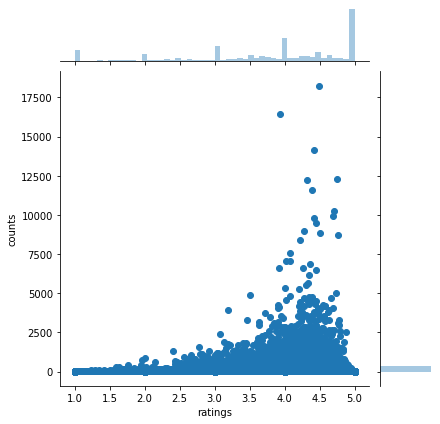

In [16]:
sns.jointplot(data=rpmeancount,x=rpmeancount['ratings'],y=rpmeancount['counts'])

It could be visually summarised that product with 4-5 ratings are more than 1-3 ratings & also number of rating (count) is more on the lower end & the data gets sparse as the product count increases

#### User Analysis

In [17]:
rumeancount = pd.DataFrame(ratings.groupby('userId')['ratings'].mean())
rumeancount['counts'] = pd.DataFrame(ratings.groupby('userId')['ratings'].count())
rumeancount.tail()

,ratings,counts
userId,,
AZZZOVIBXHGDR,3.333333,3
AZZZRS1YZ8HVP,4.000000,2
AZZZSIK7NFFVP,5.000000,1
AZZZWXXUPZ1F3,5.000000,1
AZZZY1W55XHZR,4.000000,1


In [18]:
# The user who has provided maximum ratings is the person who has given overall 520 ratings across various products
rumeancount['counts'].max()

520

In [19]:
#5 Point analysis for various users
rumeancount.describe()

,ratings,counts
count,4.201696e+06,4.201696e+06
mean,3.910163e+00,1.862220e+00
std,1.361308e+00,2.885110e+00
min,1.000000e+00,1.000000e+00
25%,3.000000e+00,1.000000e+00
50%,4.500000e+00,1.000000e+00
75%,5.000000e+00,2.000000e+00
max,5.000000e+00,5.200000e+02


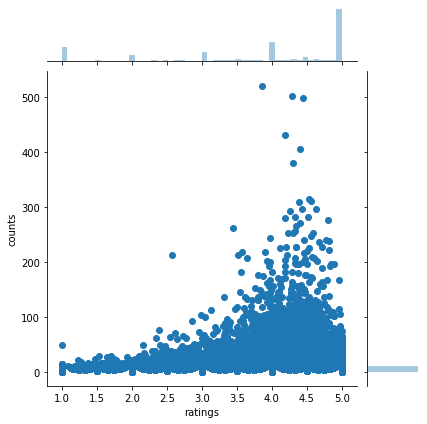

In [20]:
sns.jointplot(data=rumeancount,x=rumeancount['ratings'],y=rumeancount['counts'])

It could be seen that most of the users have provided a rating between 4-5 & average rating count per user seems to be on the lower end

#### Subsetting the data  

Since the dataset is huge by size, let us create a subset of the data. The condition used is filter out the products that have ratings count less than 100

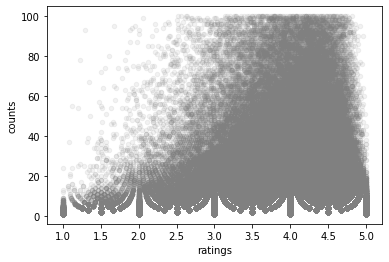

In [21]:
ax = rpmeancount[rpmeancount.counts < 101].plot(kind='scatter', x='ratings', y='counts', color='grey', alpha=0.1)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


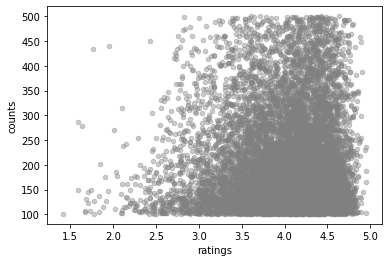

In [22]:
ax = rpmeancount[rpmeancount.counts >= 101]\
[rpmeancount.counts<501].plot(kind='scatter', x='ratings', y='counts', color='grey', alpha=0.4)
plt.show()

It could be seen from the above plots that the data is very dense when the number of ratings count is less than 100.The density gradually decreases when the number of ratings count crosses 100

In [23]:
ratings100=ratings.groupby("productId").filter(lambda x:x['ratings'].count() >100)

In [24]:
print("Size of Original Dataset:",ratings.shape)
print("Size of products that has a minimum of 100 ratings: ",ratings100.shape)
print("The number of products that have over 100 ratings is more than 50% of the overall dataset")

Size of Original Dataset: (7824481, 4)
Size of products that has a minimum of 100 ratings:  (4459079, 4)
The number of products that have over 100 ratings is more than 50% of the overall dataset


In [25]:
# Top 5 ratings of the products that has minimum 100 ratings
ratings100.groupby('productId')['ratings'].mean().sort_values(ascending=False).head()

productId
B00GMRCAC6    4.951872
B008I6RVZU    4.951456
B00CG70K78    4.949367
B000053HC5    4.945783
B008VGCT9K    4.939130
Name: ratings, dtype: float64

In [26]:
# Top 5 count of ratings of the products that has minimum 100 ratings
ratings100.groupby('productId')['ratings'].count().sort_values(ascending=False).head()

productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: ratings, dtype: int64

In [27]:
rp100meancount = pd.DataFrame(ratings100.groupby('productId')['ratings'].mean().sort_values(ascending=False))
rp100meancount['counts'] = pd.DataFrame(ratings100.groupby('productId')['ratings'].count())
rp100meancount.head()

,ratings,counts
productId,,
B00GMRCAC6,4.951872,187
B008I6RVZU,4.951456,103
B00CG70K78,4.949367,237
B000053HC5,4.945783,166
B008VGCT9K,4.939130,230


In [28]:
rp100meancount = pd.DataFrame(ratings100.groupby('productId')['ratings'].mean().sort_values(ascending=False))
rp100meancount['counts'] = pd.DataFrame(ratings100.groupby('productId')['ratings'].count())
rp100meancount.head()

,ratings,counts
productId,,
B00GMRCAC6,4.951872,187
B008I6RVZU,4.951456,103
B00CG70K78,4.949367,237
B000053HC5,4.945783,166
B008VGCT9K,4.939130,230


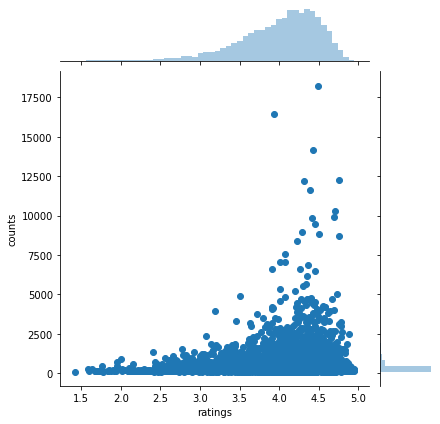

In [29]:
sns.jointplot(data=rp100meancount,x=rp100meancount['ratings'],y=rp100meancount['counts'])

sns.jointplot(data=rp100meancount,x=rp100meancount['ratings'],y=rp100meancount['counts'])

Eventhough we have taken a subset of data i.e the list of products for which there are minimum 100 ratings count, the pattern in which products/ratings are positioned is almost similar to the original dataset

#### Popularity based recommendation

As the name suggests Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now i.e out of all the products, which of them are bought most. 

In our context, the products that are rated the most number of times can be considered as most popular product. In order to find this, let us get back to the product analysis that we had done sometime back

In [30]:
rpmeancount.head()

,ratings,counts
productId,,
0321732944,5.000000,1
0439886341,1.666667,3
0511189877,4.500000,6
0528881469,2.851852,27
0558835155,3.000000,1


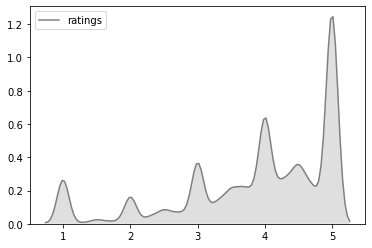

In [31]:
ax = sns.kdeplot(rpmeancount['ratings'], shade=True, color='grey')
plt.show()

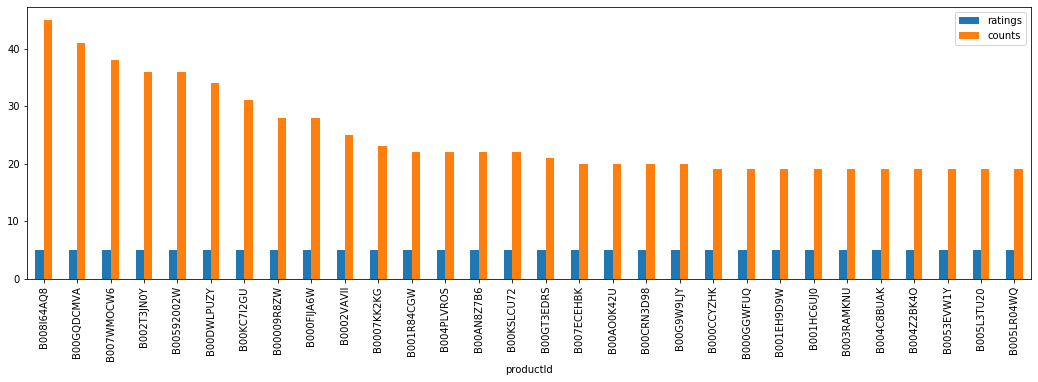

In [32]:
from pylab import rcParams
rcParams['figure.figsize'] = 18,5

popular_products = pd.DataFrame(ratings.groupby('productId')['ratings'].count())
high_rating = rpmeancount.sort_values(["ratings","counts"], ascending=False)
high_rating.head(30).plot(kind = "bar")

The above plot shows the list of products that are rated the highest(5 in our case) & the list of products are sorted by the ratings count. In a nutshell, the above is highly rated products. Even though they are highly rated, number of ratings for there products haven't crossed 50. 

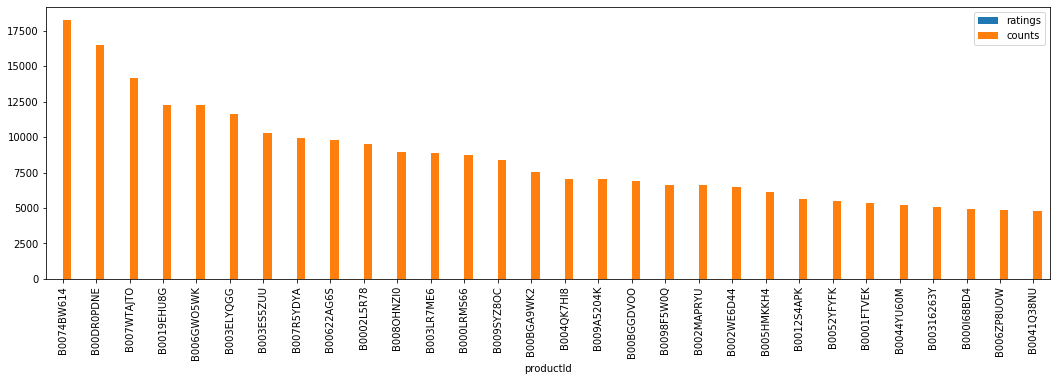

In [33]:
from pylab import rcParams
rcParams['figure.figsize'] = 18,5

popular_products = pd.DataFrame(ratings.groupby('productId')['ratings'].count())
most_popular = rpmeancount.sort_values(["counts","ratings"], ascending=False)
most_popular.head(30).plot(kind = "bar")

We could see that the product B0074BW614 has highest number of ratings (18244) & this is the most popular product & top 30 popular products are shown in the charts

### Collaborative Recommendation

collaborative filtering models which are based on assumption that people like things similar to other things they like, and things that are liked by other people with similar taste.

Nearest neighbor collaborative filtering:

In these type of recommendation systems are recommending based on nearest neighbors, nearest neighbor approach used to find out either similar users or similar products,
It can be looked at two ways: User-User filtering or Item-Item filtering
While defining the Algorithm, if 'user_based': False is set to false, then it could be treated as Item-Item filtering 

User-User filtering:
The method identifies users that are similar to the current user and estimate the desired rating to be the weighted average of the ratings of these similar users.

Item-Item filtering:
Item-item collaborative filtering is one kind of recommendation method which looks for similar items based on the items users have already liked or positively interacted with in the past.

Let us try Item-Item filtering in our dataset. Note that we are using surprise package to read the data, load the data, split the data into test/train etc.

In [34]:
reader = Reader(rating_scale=(1, 5))
df = pd.DataFrame(ratings100[['userId', 'productId', 'ratings']])

In [35]:
data = Dataset.load_from_df(df, reader)

The first approach for prediction that is tried currently is utilize the entire dataset for training. 

In [36]:
#Full Trainset
trainset = data.build_full_trainset( )

In [37]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [38]:
uid='A2CX7LUOHB2NDG'
pid='0321732944'
pred = algo.predict(uid, pid, r_ui=5, verbose=True)

user: A2CX7LUOHB2NDG item: 0321732944 r_ui = 5.00   est = 4.09   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}


It can be seen from the above approach that the original rating was 5 for the product ID/user ID combination & our algorithm has predicted the value as 4.09. The above approach can be tested for various user-product combinations like above. To my understanding, there seems to be no means to find accuracy for above approach like we do for test-train split

Now let us try our traditional test-train approach & understand the accuracy of our prediction

In [39]:
trainset, testset = train_test_split(data, test_size=.7)

In [40]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [41]:
test_pred = algo.test(testset)
test_pred

[Prediction(uid='A147259HFTG428', iid='B003C1CCJG', r_ui=4.0, est=4.087829094663095, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1XJN03ZJHGK0I', iid='B004D9WXCM', r_ui=5.0, est=4.087829094663095, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AX2ZUILPCADBW', iid='B002MMY4WY', r_ui=5.0, est=4.087829094663095, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AY5RRL56YZXTG', iid='B0011E4N2K', r_ui=5.0, est=4.087829094663095, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2GQVOO46KNI1G', iid='B00D5T3QK4', r_ui=5.0, est=4.087829094663095, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A116K4Y888NQC6', iid='B00G5R5534', r_ui=1.0, est=4.087829094663095, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AQ6XS10RR7CE0', iid

In [42]:
# get RMSE
print("Item-Item Based Model: TestSet Root Mean Squared Error (RMSE)")
accuracy.rmse(test_pred, verbose=True)

Item-Item Based Model: TestSet Root Mean Squared Error (RMSE)
RMSE: 1.3262


1.3261977050919689

#### Model Based Recommendation

There are two main approaches for CF: memory-based and model-based. Memory-based algorithm loads entire database into system memory and make prediction for recommendation based on such in-line memory database. It is simple but encounters the problem of huge data. Model-based algorithm tries to compress huge database into a model and performs recommendation task by applying reference mechanism into this model. Model-based CF can response user’s request instantly. 

The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. For now, let us consider a subset of 10000 records from the dataset

In [43]:
ratings1 = ratings.head(10000)

In [44]:
ratingsmat = ratings1.pivot_table(values='ratings', index='userId', columns='productId', fill_value=0)
ratingsmat.head()

productId,0321732944,0439886341,0511189877,0528881469,0558835155,059400232X,0594012015,0594017343,0594017580,0594033896,...,B00000J1DN,B00000J1DT,B00000J1E6,B00000J1EC,B00000J1EJ,B00000J1EP,B00000J1EQ,B00000J1ES,B00000J1EZ,B00000J1F3
userId,,,,,,,,,,,,,,,,,,,,,
A00766851QZZUBOVF4JFT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A01255851ZO1U93P8RKGE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0402564TCEO67AUZFJO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
#10000 records, when grouped by products & users, we are able to see 9826 distinct users & 1304 products
ratingsmat.shape

(9826, 1304)

In [46]:
SVDmat=ratingsmat.T
SVDmat.head()

userId,A00766851QZZUBOVF4JFT,A01255851ZO1U93P8RKGE,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0402564TCEO67AUZFJO,A04256643L1ZMT75HVD2P,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A07865442XT0VEAVPSGX1,...,AZV9WA9MNT0FB,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXFQVG0PS3V1,AZYNQZ94U6VDB,AZYTSU42BZ7TP,AZZ77XYX8O2WE,AZZGUU97OHUF1,AZZMV5VT9W7Y8
productId,,,,,,,,,,,,,,,,,,,,,
0321732944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0439886341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0511189877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,0,0,0,0
0528881469,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0558835155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
SVDmat.shape

(1304, 9826)

In [48]:
 # Fitting the algorithm / decomposing the matrix based on n users
SVD = TruncatedSVD(n_components=10)
SVDout = SVD.fit_transform(SVDmat)
SVDout.shape

(1304, 10)

In [49]:
# Finding the correlation between all the products with the item purchased by this customer ...
# (contd...) based on items rated by other customers people who bought the same product
correlmat = np.corrcoef(SVDout)
correlmat.shape

(1304, 1304)

In [50]:
# Let us consider a random index & try to find out the Top 5 products that are closely related to to chosen product
SVDmat.index[100]

'1616855711'

In [51]:
x = "1616855711"
product_names = list(SVDmat.index)
product_ID = product_names.index(x)
product_ID

100

In [52]:
#Choosing the products for which correlation coefficient is more than 0.90
correlation_product_ID = correlmat[product_ID]
Recommend = list(SVDmat.index[correlation_product_ID > 0.90])
Recommend.remove(x) 
Recommend[0:4]

['0594451647', '089933623X', '0977703037', '1094441252']

The top 5 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website is identified.

#### Conclusion

Each of the recommendation system have a vital role to play & each of them has demerits too. Where the recommendation system is being used signifies whether the recommendation would be useful or not. For instance, when a new user enters into the system, we need to recommend Popularity based model & so on. When the user has interated with a product, we can recommend collaborative filtering & so on. It can increase the user engagement & thereby helps to make the contents more personalized.It can help the item providers to deliver the items to the right user.